In [3]:
import os
import sys
import json
import shutil
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle, Polygon, Arrow
from matplotlib.collections import PatchCollection
from PIL import Image
import xml.etree.ElementTree as ET
import glob
from collections import defaultdict
from pascal_voc_writer import Writer
from tqdm import tqdm
import multiprocessing
from multiprocessing import Process, Manager
from pdf2image import convert_from_path
from PyPDF2 import PdfFileReader
import copy
from bbox import compute_ioa_batch
import functools



class_map = {'table': 0,
             'column': 1,
             'row': 2,
             'header': 3,
             'cell': 4}


import re
# as per recommendation from @freylis, compile once only
CLEANR = re.compile('<.*?>')

def cleanhtml(raw_html):
    cleantext = re.sub(CLEANR, '', raw_html)
    return cleantext


def next_tag_not_span(tag_current_idx, table_html, span_type='colspan'):
    if (tag_current_idx+1 >= len(table_html) or span_type not in table_html[tag_current_idx+1]) and \
        (tag_current_idx+2 >= len(table_html) or span_type not in table_html[tag_current_idx+2]):
        return True
    return False

def next_or_previous_tag_not_span(tag_current_idx, table_html, span_type='colspan'):
    if (tag_current_idx+1 >= len(table_html) or span_type not in table_html[tag_current_idx+1]) and \
        (tag_current_idx-1 < 0 or span_type not in table_html[tag_current_idx-1]):
        return True
    return False



def process_files(json_str, dataset_name, is_lock=True):
    class_map = {'table': 0,
                 'column': 1,
                 'row': 2,
                 'header': 3,
                 'cell': 4}
    is_visualize = False

    try:
        json_str = json_str.replace('[" ", ]', '[" "]').replace("\\","\\")
        result = json.loads(json_str)
    except Exception as e:
        print(e)
        print('error loading gt json')
        print(json_str)
        sys.exit()
        return
    dataset_type = result['split']

    file_name_split = result['filename'].replace('/', '_').split('.')
    new_file_name = '_'.join(file_name_split[:-1]) + '.' + file_name_split[-1]

    if not os.path.exists( os.path.join(dataset_name, 'images', new_file_name)):
        shutil.move(os.path.join(dataset_name, 'images', dataset_type, result['filename']),
                    os.path.join(dataset_name, 'images', new_file_name))
    im = Image.open(os.path.join(dataset_name, 'images', new_file_name))

    if is_visualize:
        fig, ax = plt.subplots(figsize=(30, 15))
        ax.imshow(im)

    cells = []
    for cell in result['html']['cells']:
        cell_box = cell.get('bbox')

        if cell_box is not None:
            # Something specific for the synthtabnet, bbox contains 1 at position idx 4 if it does not contain any tokens
            if cell_box[4] == 1 or (cell_box[2] - cell_box[1] == 0) or (cell_box[3] - cell_box[1] == 0):
                cell_box = None
            elif cell_box[4] == 2:
                cell_box = cell_box[:4]
                cell_box[0] = int(cell_box[0])
                cell_box[1] = int(cell_box[1])
                cell_box[2] = int(cell_box[2])
                cell_box[3] = int(cell_box[3])
        cells.append([cleanhtml(''.join(cell['tokens']).strip()), cell_box])

    table_cells = []
    cell_rects = []
    for cell in cells:
        bbox = cell[1]

        if bbox is not None:
            table_cells.append(bbox)
            rect = Polygon(np.asarray([[bbox[0], bbox[1]],
                                       [bbox[2], bbox[1]],
                                       [bbox[2], bbox[3]],
                                       [bbox[0], bbox[3]]]).reshape(-1, 2))
            cell_rects.append(rect)

    table_cells = np.asarray(table_cells)

    if is_visualize:
        ax.add_collection(PatchCollection(cell_rects, facecolor='none', edgecolor='red'))

    table_html = result['html']['structure']['tokens']
    headers = []
    rows = []
    rows_aux = []
    columns = []
    columns_to_cells_aux = defaultdict(list)
    rows_to_cells_aux = defaultdict(list)

    cell_idx = 0
    col_idx = 0
    max_col_idx = 0
    is_header = False
    is_row = False
    row_spans = {}

    for tag_current_idx, tag in enumerate(table_html):
        if tag == '<thead>':
            header = []
            is_header = True
            col_idx = 0
        elif tag == '</thead>':
            is_header = False

        if tag == '<tr>':
            row = []
            is_row = True
            col_idx = 0

        elif tag == '</tr>':
            if max_col_idx != 0:
                if max_col_idx != col_idx:
                    # print('bug', result['filename'])
                    # print(table_html)
                    return
            else:
                max_col_idx = col_idx

            is_row = False
            if is_header:
                headers.append(header)
                header = []
            else:
                rows.append(row)

        if 'colspan' in tag:
            tag_tmp = int(tag.strip().replace('colspan="', '').replace('"', '').replace("'", ""))
            for i in range(col_idx, col_idx + tag_tmp):
                if len(columns) <= i:
                    columns.append([])
                    
                if cells[cell_idx-1][1] is not None:
                    columns_to_cells_aux[i].append(cells[cell_idx-1][1])
            col_idx += tag_tmp

        if 'rowspan' in tag:
            row_span = int(tag.strip().replace('rowspan="', '').replace('"', '').replace("'", ""))
            row_span -= 1
            for i in range(len(rows) + len(headers), len(rows) + len(headers) + row_span + 1):
                if cells[cell_idx-1][1] is not None:
                    rows_to_cells_aux[i].append(cells[cell_idx-1][1])

            # if not already increased col_idx by colspan
            if next_or_previous_tag_not_span(tag_current_idx, table_html, 'colspan'):
                row_spans[col_idx] = row_span
                col_idx += 1
            else:
                if 'colspan' in table_html[tag_current_idx+1]:
                    row_spans[col_idx] = row_span
                    tag_tmp = table_html[tag_current_idx+1]
                    tag_tmp = int(tag_tmp.strip().replace('colspan="', '').replace('"', '').replace("'", ""))
                    for i in range(col_idx, col_idx + tag_tmp):
                        row_spans[i] = row_span
                else:
                    tag_tmp = table_html[tag_current_idx-1]
                    tag_tmp = int(tag_tmp.strip().replace('colspan="', '').replace('"', '').replace("'", ""))
                    for i in range(col_idx-tag_tmp, col_idx):
                        row_spans[i] = row_span

        if 'rowspan' not in tag and col_idx in list(row_spans.keys()):
            while row_spans.get(col_idx, 0) > 0:
                row_spans[col_idx] = row_spans[col_idx] - 1
                col_idx += 1

        if tag in ['<td>', '<td']:
            if is_header and is_row:
                if len(columns) <= col_idx:
                    for _ in range(col_idx - len(columns) + 1):
                        columns.append([])
                if cells[cell_idx][1] is not None:
                    if tag == '<td>' or (tag == '<td' and next_tag_not_span(tag_current_idx, table_html, 'rowspan')):
                        header.append(cells[cell_idx][1])
                    if tag == '<td>' or (tag == '<td' and next_tag_not_span(tag_current_idx, table_html, 'colspan')):
                        columns[col_idx].append(cells[cell_idx][1])
                cell_idx += 1
            elif is_row:
                if len(columns) <= col_idx:
                    for _ in range(col_idx - len(columns) + 1):
                        columns.append([])
                if cells[cell_idx][1] is not None:
                    if tag == '<td>' or (tag == '<td' and next_tag_not_span(tag_current_idx, table_html, 'rowspan')):
                        row.append(cells[cell_idx][1])
                    if tag == '<td>' or (tag == '<td' and next_tag_not_span(tag_current_idx, table_html, 'colspan')):
                        columns[col_idx].append(cells[cell_idx][1])
                cell_idx += 1

        if tag == '<td>':
            col_idx += 1

    if is_lock:
        lock.acquire()

    column_boxes = []
    row_boxes = []

    json_writer = {'image_size': [int(im.size[0]), int(im.size[1])], 'labels': []}

    # if some table was already detected for that file then read it before appending a new table to that file
    json_path = os.path.join(dataset_name, dataset_type, '_'.join(result['filename'].replace('/', '_').split('.')[:-1]) + '.json')
    if os.path.exists(json_path):
        with open(json_path, 'r') as openfile:
            json_writer = json.load(openfile)

    json_writer['labels'].append({'name': 'table',
                                  'bbox': [int(np.amin(table_cells[:, 0])),
                                           int(np.amin(table_cells[:, 1])),
                                           int(np.amax(table_cells[:, 2])),
                                           int(np.amax(table_cells[:, 3]))]})

    rects = []
    row_arrows = []
    # headers are also rows
    new_rows = headers.copy()
    new_rows.extend(rows)
    rows = new_rows
    for row_idx, row in enumerate(rows):
        row = [r for r in row if r != []]
        if row != []:
            row = np.asarray(row).reshape(-1, 2)
            x_min = int(np.amin(row[:, 0]))
            x_max = int(np.amax(row[:, 0]))
            y_min = int(np.amin(row[:, 1]))
            y_max = int(np.amax(row[:, 1]))
            list_of_cells_to_point = rows_to_cells_aux.get(row_idx, None)

            if is_visualize:
                row_box = [[x_min, y_min], [x_max, y_min], [x_max, y_max], [x_min, y_max]]
                rect = Polygon(np.asarray(row_box).reshape(-1, 2))
                rects.append(rect)
                
                if list_of_cells_to_point is not None:
                    for dst_cell in list_of_cells_to_point:
                        if dst_cell:
                            dst_cell_x_center = (dst_cell[0] + dst_cell[2]) / 2.0
                            dst_cell_y_center = (dst_cell[1] + dst_cell[3]) / 2.0
                            row_x_center = (x_min + x_max) / 2.0
                            row_y_center = (y_min + y_max) / 2.0
                            arrow = Arrow(row_x_center, row_y_center, dst_cell_x_center-row_x_center, dst_cell_y_center-row_y_center)
                            row_arrows.append(arrow)
            row_boxes.append([x_min, y_min, x_max, y_max])
            json_writer['labels'].append({'name': 'row',
                                          'bbox': [x_min, y_min, x_max, y_max],
                                          'extra_cells': list_of_cells_to_point})

    if is_visualize:
        ax.add_collection(PatchCollection(rects, facecolor='none', edgecolor='blue'))
        ax.add_collection(PatchCollection(row_arrows, facecolor='none', edgecolor='blue'))

    rects = []
    col_arrows = []
    for col_idx, column in enumerate(columns):
        column = [c for c in column if c != []]
        if column != []:
            column = np.asarray(column).reshape(-1, 2)
            x_min = int(np.amin(column[:, 0]))
            x_max = int(np.amax(column[:, 0]))
            y_min = int(np.amin(column[:, 1]))
            y_max = int(np.amax(column[:, 1]))

            list_of_cells_to_point = columns_to_cells_aux.get(col_idx, None)

            if is_visualize:
                row_box = [[x_min, y_min], [x_max, y_min], [x_max, y_max], [x_min, y_max]]
                rect = Polygon(np.asarray(row_box).reshape(-1, 2))
                rects.append(rect)

                if list_of_cells_to_point is not None:
                    for dst_cell in list_of_cells_to_point:
                        if dst_cell:
                            dst_cell_x_center = (dst_cell[0] + dst_cell[2]) / 2.0
                            dst_cell_y_center = (dst_cell[1] + dst_cell[3]) / 2.0
                            column_x_center = (x_min + x_max) / 2.0
                            column_y_center = (y_min + y_max) / 2.0
                            arrow = Arrow(column_x_center, column_y_center, dst_cell_x_center-column_x_center, dst_cell_y_center-column_y_center)
                            col_arrows.append(arrow)
            column_boxes.append([x_min, y_min, x_max, y_max])
            json_writer['labels'].append({'name': 'column',
                                          'bbox': [x_min, y_min, x_max, y_max],
                                          'extra_cells': list_of_cells_to_point})
    if is_visualize:
        ax.add_collection(PatchCollection(rects, facecolor='none', edgecolor='green'))
        ax.add_collection(PatchCollection(col_arrows, facecolor='none', edgecolor='green'))

    rects = []
    for header in headers:
        header = [h for h in header if h != []]
        if header != []:
            header = np.asarray(header).reshape(-1, 2)
            x_min = int(np.amin(header[:, 0]))
            x_max = int(np.amax(header[:, 0]))
            y_min = int(np.amin(header[:, 1]))
            y_max = int(np.amax(header[:, 1]))
            json_writer['labels'].append({'name': 'header',
                                          'bbox': [x_min, y_min, x_max, y_max]})
            if is_visualize:
                header_box = [[x_min, y_min], [x_max, y_min], [x_max, y_max], [x_min, y_max]]
                rect = Polygon(np.asarray(header_box).reshape(-1, 2))
                rects.append(rect)
    if is_visualize:
        ax.add_collection(PatchCollection(rects, facecolor='none', edgecolor='orange'))

    for cell in cells:
        if cell[1] is not None:
            json_writer['labels'].append({'name': 'cell',
                                          'cell_idx': cell_idx,
                                          'bbox': [cell[1][0], cell[1][1], cell[1][2], cell[1][3]],
                                          'content': cell[0]})

    if len(column_boxes) > 0 and len(row_boxes) > 0:
        ioa = compute_ioa_batch(np.asarray(column_boxes), np.asarray(column_boxes), max_ioa=True)
        np.fill_diagonal(ioa, 0)
        col_ioa_max = np.amax(ioa)

        ioa = compute_ioa_batch(np.asarray(row_boxes), np.asarray(row_boxes), max_ioa=True)
        np.fill_diagonal(ioa, 0)
        row_ioa_max = np.amax(ioa)

        if col_ioa_max <= 0.5 and row_ioa_max <= 0.5:
            base_file_name = '_'.join(result['filename'].replace('/', '_').split('.')[:-1])
            with open(os.path.join(dataset_name, dataset_type, base_file_name + '.json'), "w") as outfile:
                json.dump(json_writer, outfile)
        # else:
        #     print('overlap', result['filename'])
        #     print(col_ioa_max)
        #     print(row_ioa_max)
    if is_lock:
        lock.release()



n_jobs = 32
def init(l):
    global lock
    lock = l

l = multiprocessing.Lock()

dataset_names = ['fintabnet', 'pubtabnet', 'marketing', 'sparse']

for dataset_name in dataset_names:
    with open(dataset_name + '/synthetic_data.jsonl') as json_data:
        json_list = list(json_data) # [:10]

    for dataset_type in ['train', 'test', 'val']:
        if os.path.exists(dataset_name + '/' + dataset_type):
            shutil.rmtree(dataset_name + '/' + dataset_type)
            os.makedirs(dataset_name + '/' + dataset_type)

    # for json_idx, json_str in enumerate(tqdm(json_list)):
    #     process_files(json_str, dataset_name, is_lock=False)

    with multiprocessing.Pool(n_jobs, initialize r=init, initargs=(l,)) as p:
        result = list(tqdm(p.imap(functools.partial(process_files, dataset_name=dataset_name), json_list), total=len(json_list)))

print('End')


100%|██████████| 150000/150000 [05:04<00:00, 492.01it/s]


End


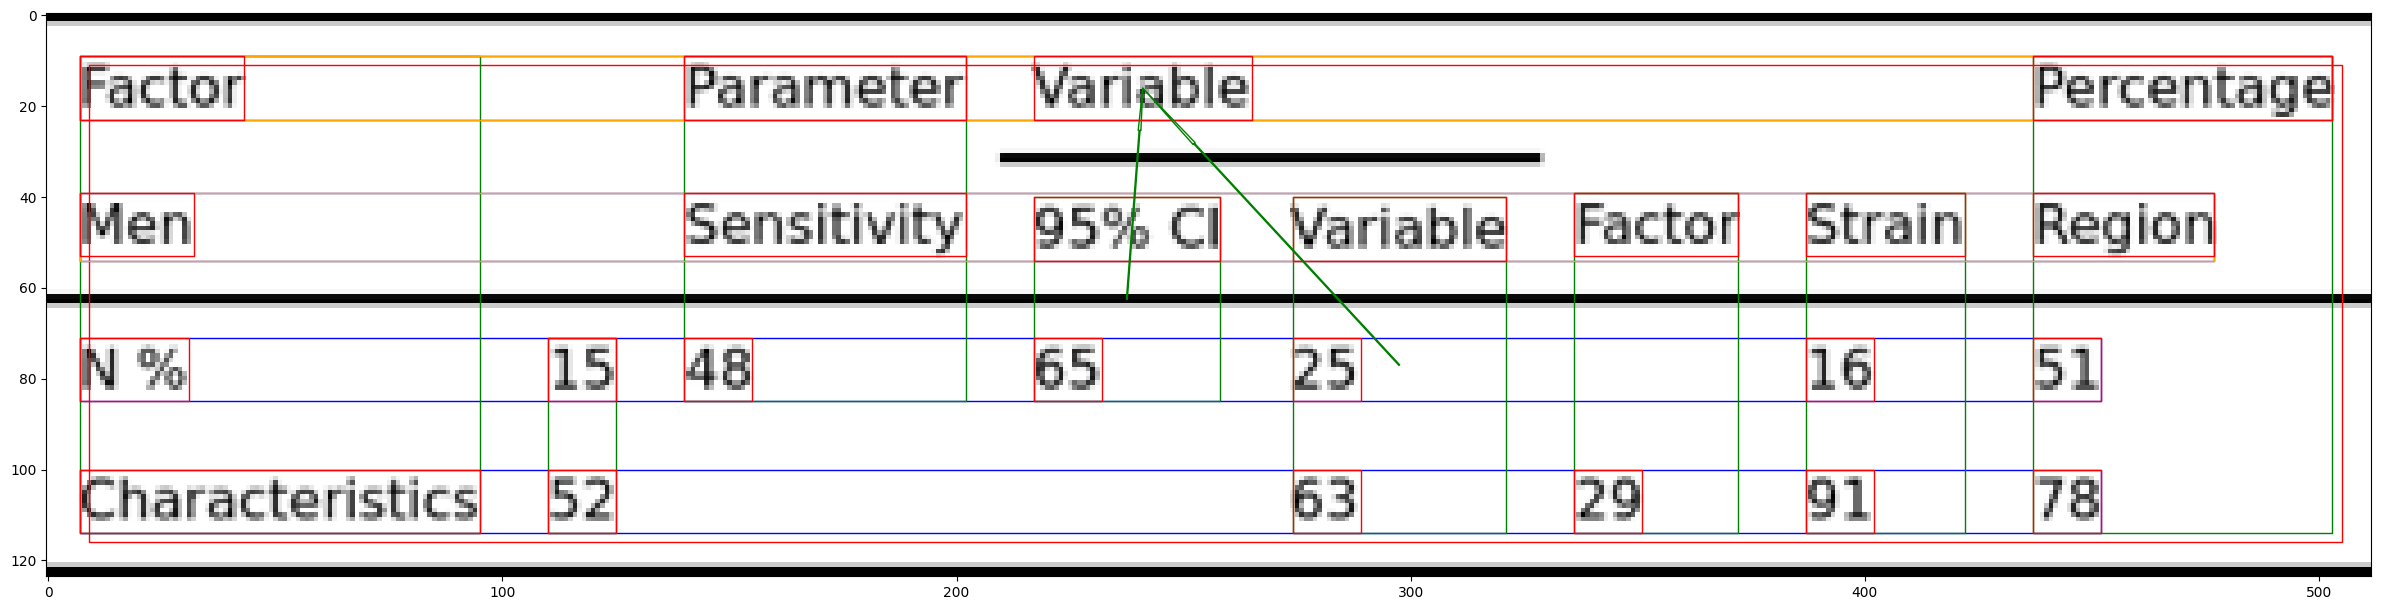

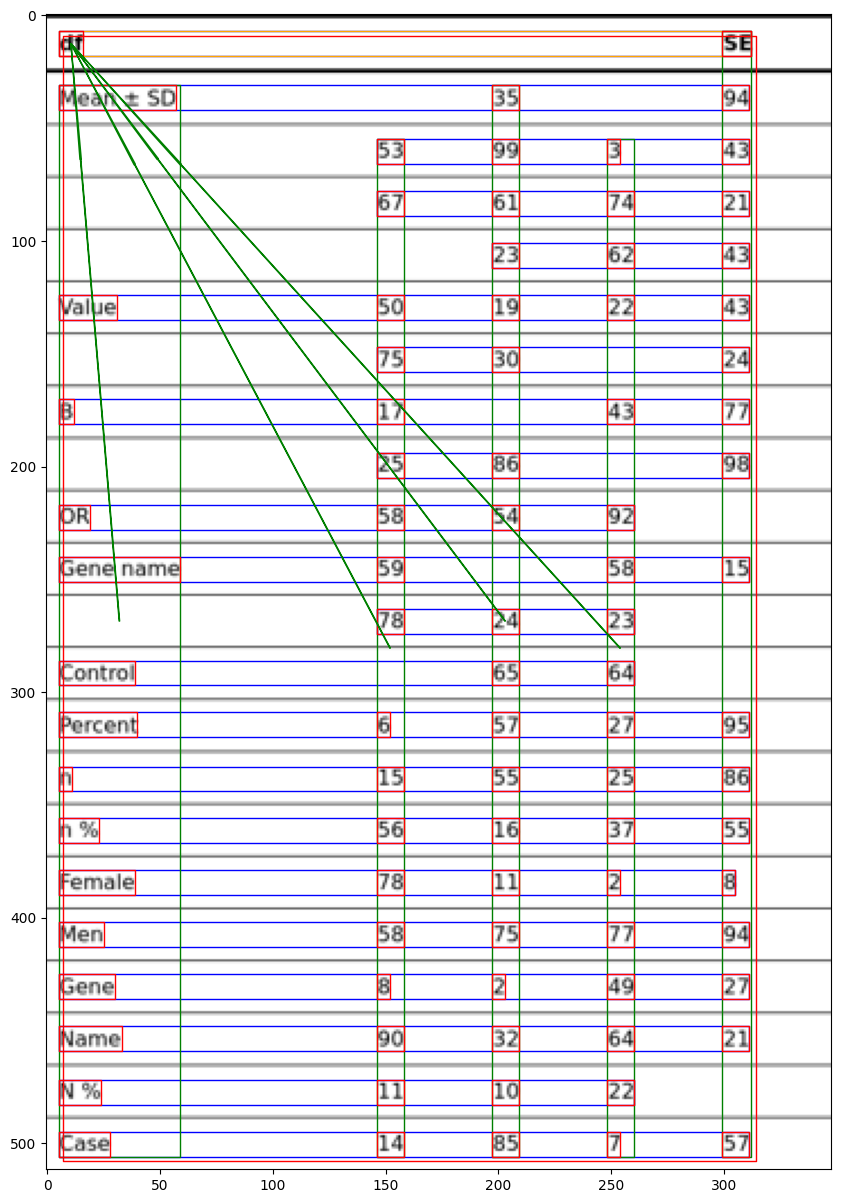

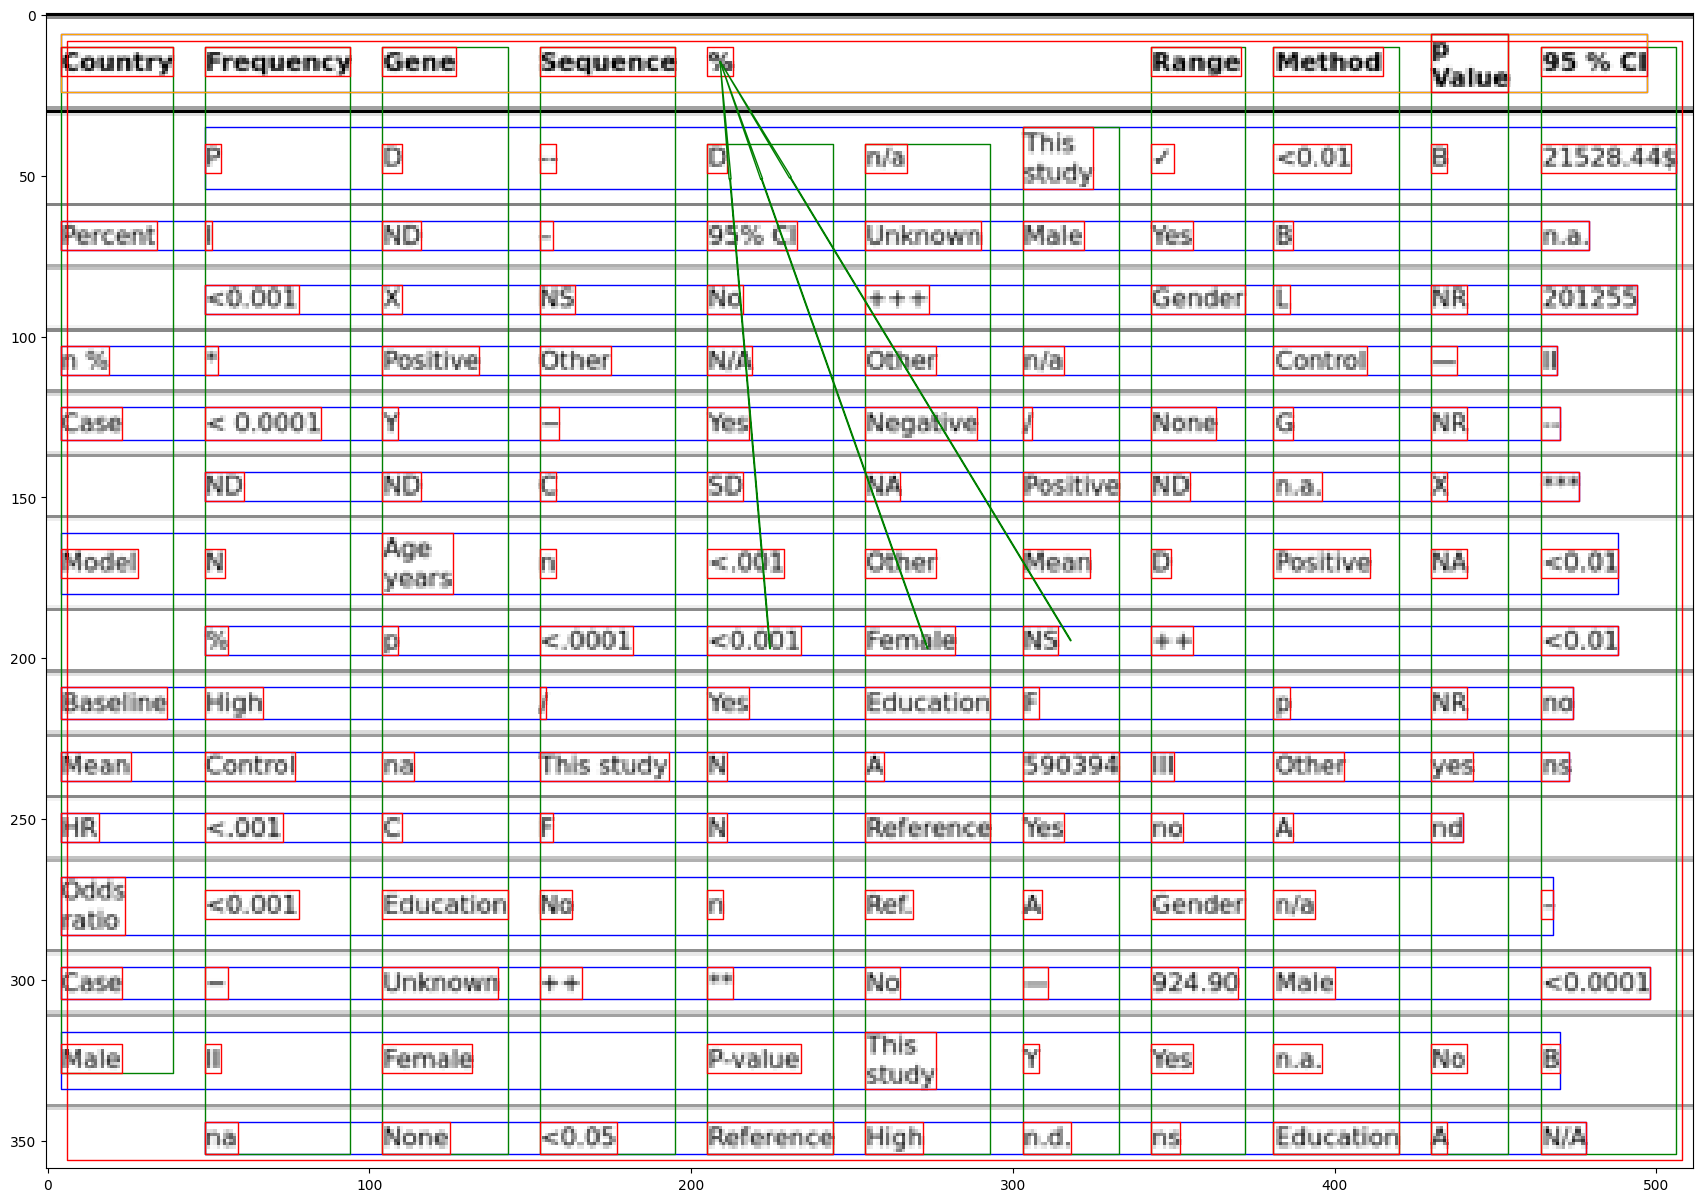

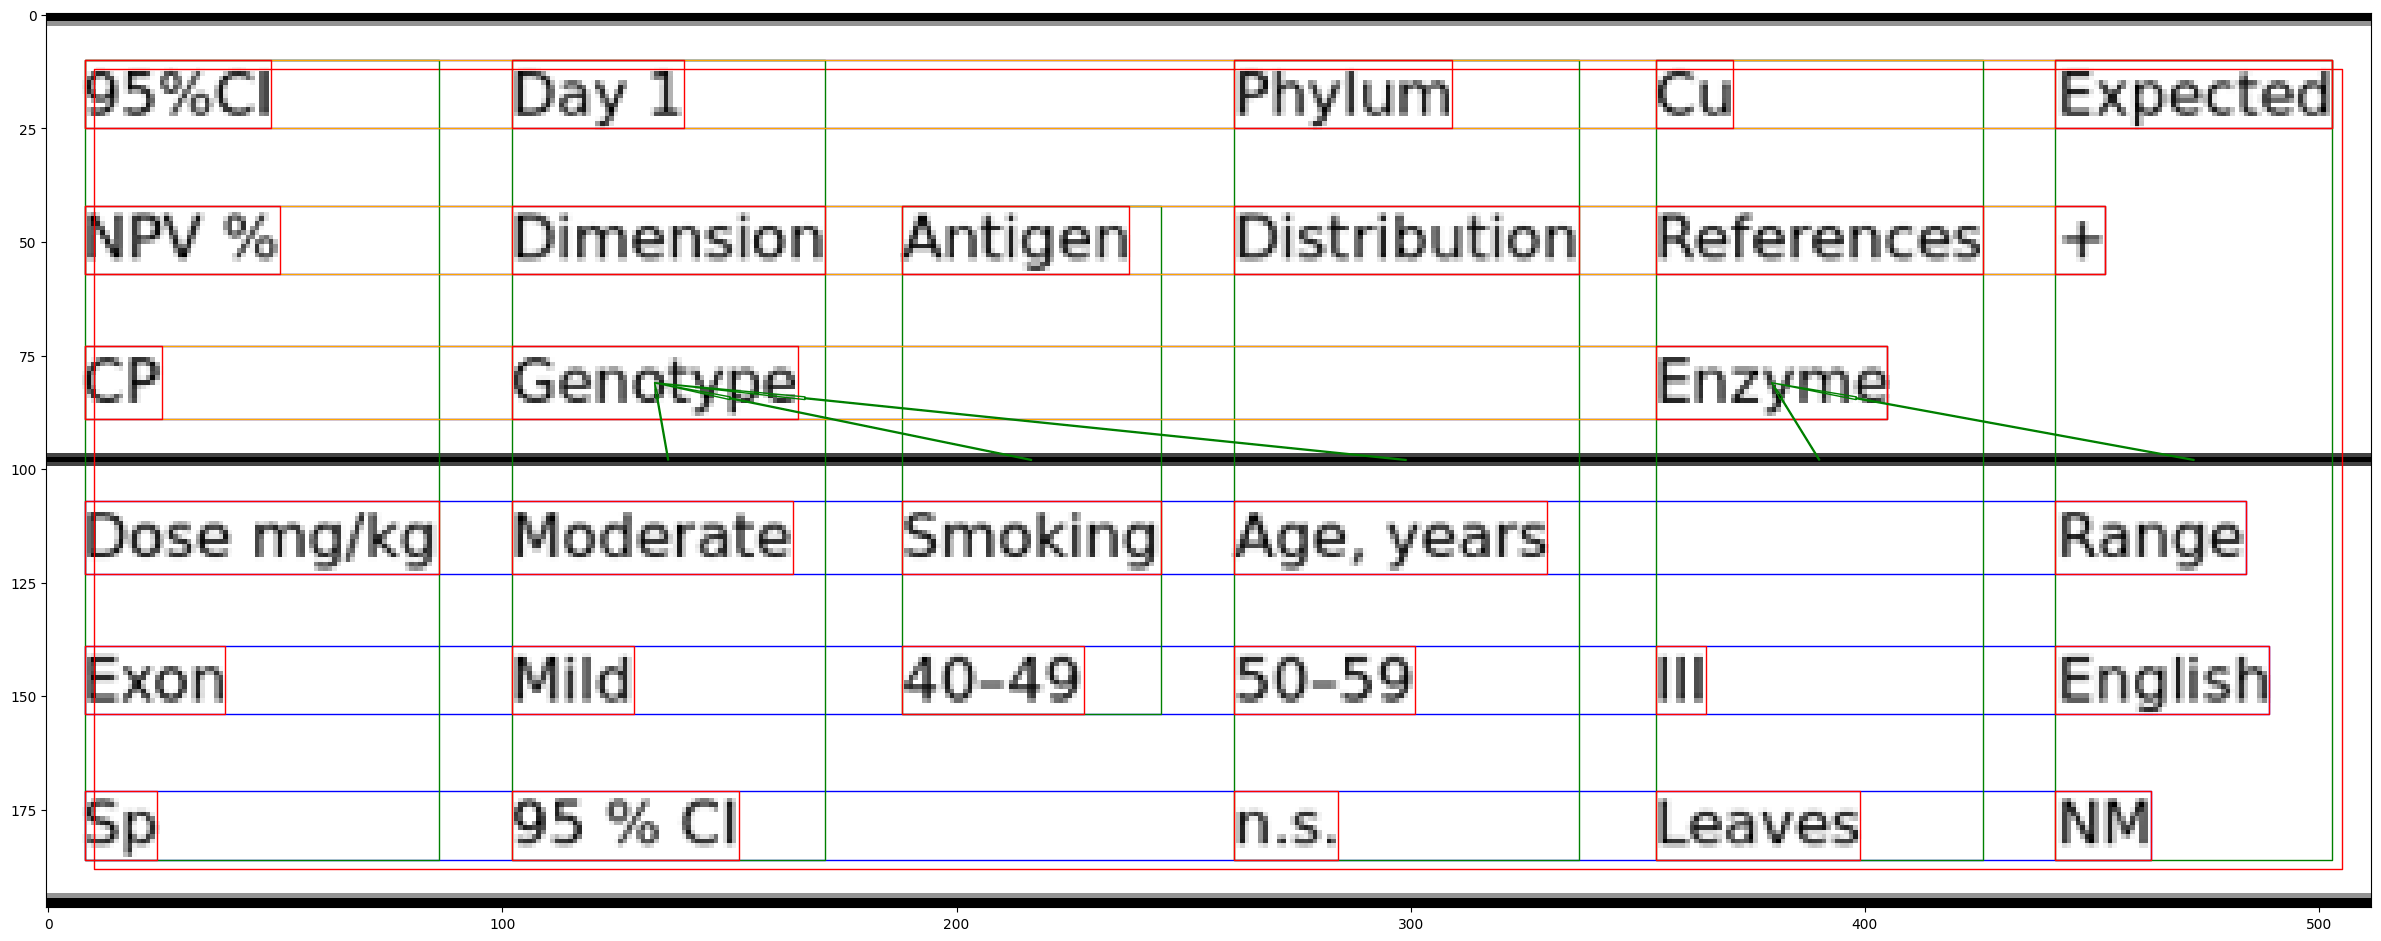

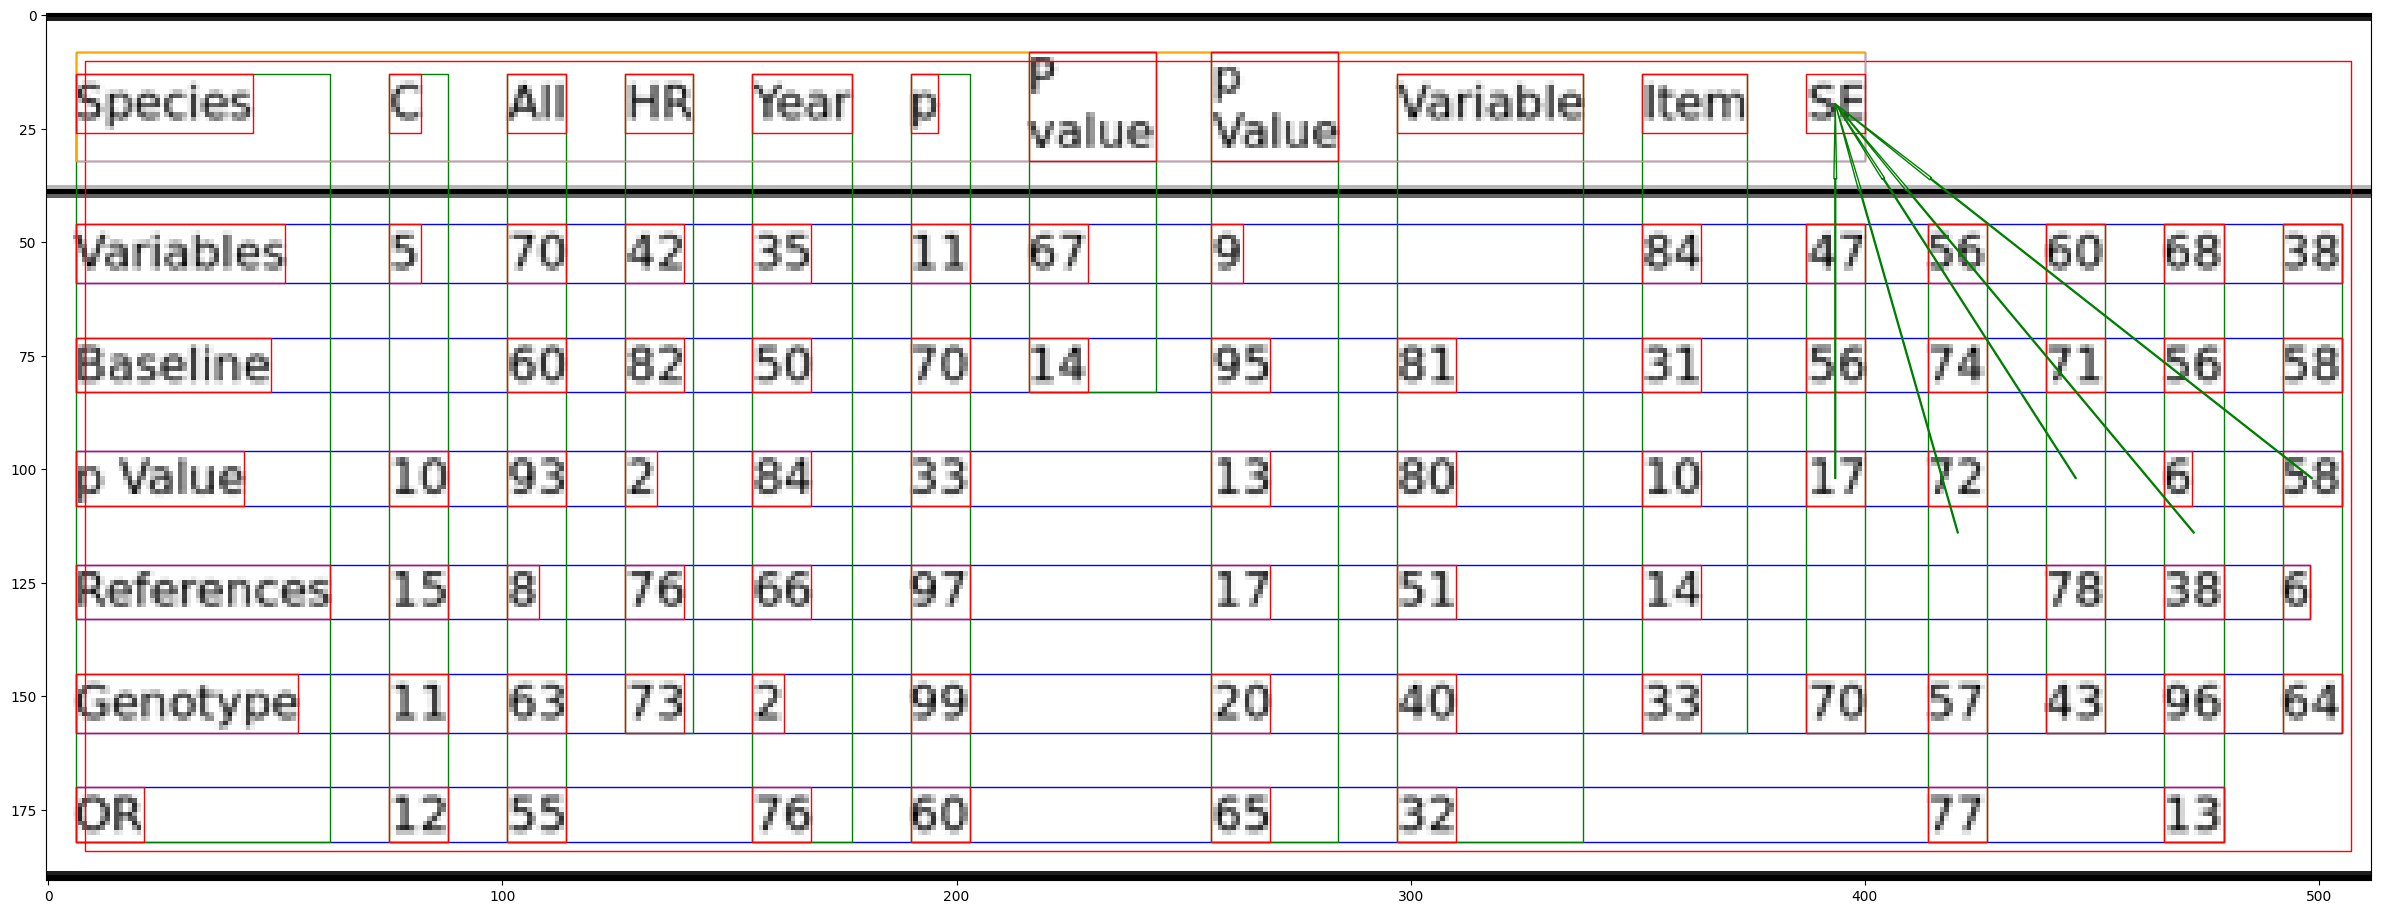

In [4]:
# labels visualization

import os
import sys
import json
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle, Polygon, Arrow
from matplotlib.collections import PatchCollection
from PIL import Image
import xml.etree.ElementTree as ET
import glob
from collections import defaultdict



def read_json(json_file: str, class_map=None):
    with open(json_file, 'r') as openfile:
        data = json.load(openfile)
    width, height = data['image_size']
    bboxes = []
    labels = []
    cell_pointers = []

    for label in data['labels']:
        label_name = label['name']
        bbox = label['bbox']
        cell_pointer = label.get('extra_cells', None)

        if label_name == 'table rotated':
            label_name = 'table'

        if class_map.get(label_name, None) is None:
            continue

        label_id = int(class_map[label_name])
        bboxes.append(bbox)
        labels.append(label_id)
        cell_pointers.append(cell_pointer)

    return bboxes, labels, cell_pointers, [width, height]


class_map = {'table': 0,
             'column': 1,
             'row': 2,
             'header': 3,
             'cell': 4}

dataset_names = ['pubtabnet'] # 'pubtabnet', 'marketing', 'sparse'

for dataset_name in dataset_names:
    dataset_type = 'train'
    dataset_path = os.path.join(dataset_name, dataset_type)

    for f in os.listdir(dataset_path)[:5]:
        if f == '.ipynb_checkpoints':
            continue

        file_name = f.split('.')[0]
        annotation_file_path = os.path.join(dataset_path, f)
        bboxes, labels, cell_pointers, size = read_json(annotation_file_path, class_map)

        image_path = os.path.join(dataset_path, '..', 'images', file_name + '.jpg')
        if not os.path.exists(image_path):
            image_path = os.path.join(dataset_path, '..', 'images', file_name + '.png')

        im = Image.open(image_path)
        fig, ax = plt.subplots(figsize=(30, 15))
        ax.imshow(im)
        header_rects = []
        row_rects = []
        col_rects = []
        table_rects = []
        cell_rects = []
        col_arrows = []
        row_arrows = []

        for idx, bbox in enumerate(bboxes):
            if labels[idx] == 0:
                shift = 2
            else:
                shift = 0
            rect = Polygon(np.asarray([[bbox[0] + shift, bbox[1] + shift], [bbox[2] + shift, bbox[1] + shift],
                                       [bbox[2] + shift, bbox[3] + shift], [bbox[0] + shift, bbox[3] + shift]]).reshape(-1, 2))
            if labels[idx] == 0:
                table_rects.append(rect)
            elif labels[idx] == 1:
                col_rects.append(rect)
            elif labels[idx] == 2:
                row_rects.append(rect)
            elif labels[idx] == 3:
                header_rects.append(rect)
            elif labels[idx] == 4:
                cell_rects.append(rect)

            if labels[idx] == 1:
                if cell_pointers[idx]:
                    for dst_cell in cell_pointers[idx]:
                        if dst_cell:
                            dst_cell_x_center = (dst_cell[0] + dst_cell[2]) / 2.0
                            dst_cell_y_center = (dst_cell[1] + dst_cell[3]) / 2.0
                            column_x_center = (bbox[0] + bbox[2]) / 2.0
                            column_y_center = (bbox[1] + bbox[3]) / 2.0
                            arrow = Arrow(column_x_center, column_y_center, dst_cell_x_center-column_x_center, dst_cell_y_center-column_y_center)
                            col_arrows.append(arrow)

            if labels[idx] == 2:
                if cell_pointers[idx]:
                    for dst_cell in cell_pointers[idx]:
                        if dst_cell:
                            dst_cell_x_center = (dst_cell[0] + dst_cell[2]) / 2.0
                            dst_cell_y_center = (dst_cell[1] + dst_cell[3]) / 2.0
                            row_x_center = (bbox[0] + bbox[2]) / 2.0
                            row_y_center = (bbox[1] + bbox[3]) / 2.0
                            arrow = Arrow(row_x_center, row_y_center, dst_cell_x_center-row_x_center, dst_cell_y_center-row_y_center)
                            row_arrows.append(arrow)

        ax.add_collection(PatchCollection(table_rects, facecolor='none', edgecolor='red'))
        ax.add_collection(PatchCollection(row_rects, facecolor='none', edgecolor='blue'))
        ax.add_collection(PatchCollection(col_rects, facecolor='none', edgecolor='green'))
        ax.add_collection(PatchCollection(header_rects, facecolor='none', edgecolor='orange'))
        ax.add_collection(PatchCollection(cell_rects, facecolor='none', edgecolor='red'))
        ax.add_collection(PatchCollection(col_arrows, facecolor='none', edgecolor='green'))
        ax.add_collection(PatchCollection(row_arrows, facecolor='none', edgecolor='blue'))
